import packages 

In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *
from repo.Optimization import *

# Read In

Import the config file and set the config dict. set some variables from the config dict

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/config ups emea.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

# Read data

Read the cuts df, hyper parameter table 

In [3]:
# Get forecasters
cuts_df = pd.read_csv(base_path + 'New_Cuts_df EU.csv')
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' #' 05.19.2021 Final.pkl'
cuts_df['periods'] = periods
cuts_df


,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,new_confirmed,Nov_Dec_2018,Jul_Dec_2019,dec_2022,power,growth,MAPE,period_AE,forecaster_name_list,periods
0,France,-,Brand,0.0010,0.01,10.00,additive,multiplicative,na,default,...,na,na,na,na,na,linear,12.60,1.72,France - Brand.pkl,252.0
1,France,-,Non_Brand,0.0001,0.01,1.00,multiplicative,multiplicative,multiplicative,default,...,na,na,na,na,na,linear,23.42,21.990.000.000.000.000,France - Non_Brand.pkl,252.0
2,Germany,-,Brand,0.0500,1.00,10.00,multiplicative,multiplicative,additive,default,...,na,na,na,na,na,linear,6.40,1.96,Germany - Brand.pkl,252.0
3,Germany,-,Non_Brand,0.0010,0.01,1.00,additive,additive,multiplicative,default,...,na,na,na,na,na,linear,13.54,13.78,Germany - Non_Brand.pkl,252.0
4,Italy,-,Brand,0.0010,0.01,0.10,multiplicative,multiplicative,multiplicative,default,...,na,na,na,na,na,linear,5.11,1.42,Italy - Brand.pkl,252.0
5,Italy,-,Non_Brand,0.0500,0.01,10.00,additive,additive,multiplicative,na,...,na,na,na,na,na,linear,15.82,4.02,Italy - Non_Brand.pkl,252.0
6,Poland,-,Brand,0.1000,0.01,10.00,additive,additive,multiplicative,na,...,na,na,na,na,na,linear,6.07,0.36,Poland - Brand.pkl,252.0
7,Poland,-,Non_Brand,0.1000,0.01,0.10,multiplicative,additive,na,na,...,na,na,na,na,na,linear,27.96,20.830.000.000.000.000,Poland - Non_Brand.pkl,252.0
8,SM,-,-,0.0010,0.01,0.01,additive,multiplicative,na,default,...,na,na,na,multiplicative,na,logistic,11.42,3.37,SM - -.pkl,252.0
9,UK,-,Brand,0.0500,0.01,1.00,multiplicative,multiplicative,additive,default,...,na,na,na,na,na,logistic,19.26,9.87,UK - Brand.pkl,252.0


get the list of pickle files 

In [4]:
# get model list
forecasters_array = cuts_df.forecaster_name_list
forecasters_array

0          France - Brand.pkl
1      France - Non_Brand.pkl
2         Germany - Brand.pkl
3     Germany - Non_Brand.pkl
4           Italy - Brand.pkl
5       Italy - Non_Brand.pkl
6          Poland - Brand.pkl
7      Poland - Non_Brand.pkl
8                  SM - -.pkl
9              UK - Brand.pkl
10         UK - Non_Brand.pkl
11          India - Brand.pkl
12      India - Non_Brand.pkl
Name: forecaster_name_list, dtype: object

import the analytical file

In [5]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path, index_col = 0)
analytical_file['ds'] = pd.to_datetime(analytical_file['ds'])
analytical_file


,ds,region,market,account_type,funnel,Identifier,X,revenue,new_funnel,generic_cost,...,UK_-_Brand_Sep_2024,UK_-_Non_Brand_Apr_2024,UK_-_Non_Brand_Aug_2024,UK_-_Non_Brand_Dec_2024,UK_-_Non_Brand_Jul_2024,UK_-_Non_Brand_Jun_2024,UK_-_Non_Brand_May_2024,UK_-_Non_Brand_Nov_2024,UK_-_Non_Brand_Oct_2024,UK_-_Non_Brand_Sep_2024
0,2024-04-25,Europe,France,-,Brand,L,3867.3200,39320.913507,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-04-25,Europe,France,-,Non_Brand,L,185.3300,1700.537720,0,139.0700,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-04-25,Europe,Germany,-,Brand,L,4192.8800,44622.107477,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-04-25,Europe,Germany,-,Non_Brand,L,472.7200,3333.379901,0,255.4900,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-04-25,Europe,India,-,Brand,L,668.5700,18969.429558,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,2024-12-31,Europe,Poland,-,Brand,L,289.4350,5319.808425,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3259,2024-12-31,Europe,Poland,-,Non_Brand,L,33.9100,344.225395,0,13.5200,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3260,2024-12-31,Europe,SM,-,-,S,3166.0965,57201.250833,BrandNon_BrandNon_BrandBrandNon_BrandNon_Brand...,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3261,2024-12-31,Europe,UK,-,Brand,L,4183.4900,16074.924459,0,0.0000,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


import the constraint file

In [6]:
# Get constrain file
constraint_file = pd.read_csv(base_path + 'Constraint File 31.05.24.csv')
constraint_file['init'] = constraint_file[['MinWeight', 'MaxWeight']].mean(axis = 1)
constraint_file

,market,account_type,funnel,Month,Year,variable_splits,Constrain_Variable_Name,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,...,power,growth,MAPE,period_AE,periods,periods_for_acc_cal,cutoff_month,MinWeight,MaxWeight,init
0,France,-,Brand,Apr,2024,France_-_Brand_Apr_2024,cost,0.0010,0.01,10.00,...,na,linear,12.60,1.72,252.0,183,24/04/24,0.8,1.2,1.0
1,France,-,Non_Brand,Apr,2024,France_-_Non_Brand_Apr_2024,cost,0.0001,0.01,1.00,...,na,linear,23.42,21.990.000.000.000.000,252.0,183,24/04/24,0.8,1.2,1.0
2,Germany,-,Brand,Apr,2024,Germany_-_Brand_Apr_2024,cost,0.0500,1.00,10.00,...,na,linear,6.40,1.96,252.0,183,24/04/24,0.8,1.2,1.0
3,Germany,-,Non_Brand,Apr,2024,Germany_-_Non_Brand_Apr_2024,cost,0.0010,0.01,1.00,...,na,linear,13.54,13.78,252.0,183,24/04/24,0.8,1.2,1.0
4,India,-,Brand,Apr,2024,India_-_Brand_Apr_2024,cost,0.1000,0.01,1.00,...,na,logistic,17.03,13.54,252.0,183,24/04/24,0.8,1.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Poland,-,Brand,Dec,2024,Poland_-_Brand_Dec_2024,cost,0.1000,0.01,10.00,...,na,linear,6.07,0.36,252.0,183,24/04/24,0.8,1.2,1.0
113,Poland,-,Non_Brand,Dec,2024,Poland_-_Non_Brand_Dec_2024,cost,0.1000,0.01,0.10,...,na,linear,27.96,20.830.000.000.000.000,252.0,183,24/04/24,0.8,1.2,1.0
114,SM,-,-,Dec,2024,SM_-_-_Dec_2024,cost,0.0010,0.01,0.01,...,na,logistic,11.42,3.37,252.0,183,24/04/24,0.8,1.2,1.0
115,UK,-,Brand,Dec,2024,UK_-_Brand_Dec_2024,cost,0.0500,0.01,1.00,...,na,logistic,19.26,9.87,252.0,183,24/04/24,0.8,1.2,1.0


# PSO Functions

Initialize the SavantPSO class function with the cuts, analytical and constraint file, also include the config dict

In [7]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

set PSO hyper parameters

In [8]:
itNum = 150
n_particles = 0
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}


optimize the budget allocation setting optimized input weights that maximize conversion quantity. <br>
    run_pso method of SavantPSO class function, with PSO hyper parameters

In [ ]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum)

2024-06-05 02:51:16,477 - pyswarms.single.global_best - INFO - Optimize for 150 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/Input Weight History 06.05.2024.csv


pyswarms.single.global_best:   0%|          |0/150

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---

pyswarms.single.global_best:   1%|          |1/150, best_cost=-9.12e+5

yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913632.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915358.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910455.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913874.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:   1%|▏         |2/150, best_cost=-9.18e+5

yhat: -909951.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913931.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917599.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -912724.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -914524.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:   2%|▏         |3/150, best_cost=-9.23e+5

yhat: -900941.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -905999.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906100.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -912243.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917840.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  26%|██▌       |39/150, best_cost=-9.29e+5

yhat: -911656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914598.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916748.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909093.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  29%|██▊       |43/150, best_cost=-9.29e+5

yhat: -914177.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911948.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911949.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  29%|██▉       |44/150, best_cost=-9.29e+5

yhat: -919312.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919595.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -916391.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914210.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919609.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  30%|███       |45/150, best_cost=-9.29e+5

yhat: -917250.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -925164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -906276.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913344.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906651.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  31%|███       |46/150, best_cost=-9.29e+5

yhat: -915342.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918280.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -911192.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918118.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907361.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  31%|███▏      |47/150, best_cost=-9.29e+5

yhat: -915967.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -917971.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912509.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910485.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924179.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  32%|███▏      |48/150, best_cost=-9.29e+5

yhat: -915207.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -922745.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907264.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913445.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912372.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  33%|███▎      |49/150, best_cost=-9.29e+5

yhat: -912620.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919954.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -914756.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915645.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913659.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  33%|███▎      |50/150, best_cost=-9.29e+5

yhat: -915290.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917971.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912707.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -921593.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907037.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  34%|███▍      |51/150, best_cost=-9.29e+5

yhat: -914484.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -911356.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911557.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  35%|███▍      |52/150, best_cost=-9.3e+5 

yhat: -910621.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913521.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908119.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913714.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916793.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  35%|███▌      |53/150, best_cost=-9.32e+5

yhat: -917454.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918409.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906507.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913609.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912375.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  36%|███▌      |54/150, best_cost=-9.32e+5

yhat: -913505.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918278.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -911009.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918499.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -907785.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  37%|███▋      |55/150, best_cost=-9.32e+5

yhat: -912893.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -910470.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910076.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -912772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -916771.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  37%|███▋      |56/150, best_cost=-9.32e+5

yhat: -911414.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915873.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915952.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916433.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -913849.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  38%|███▊      |57/150, best_cost=-9.32e+5

yhat: -916348.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -922724.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908113.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915181.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920592.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  39%|███▊      |58/150, best_cost=-9.32e+5

yhat: -915386.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916988.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906582.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -926668.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918936.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  39%|███▉      |59/150, best_cost=-9.32e+5

yhat: -908320.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918699.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915139.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907629.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908304.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  40%|████      |60/150, best_cost=-9.32e+5

yhat: -914091.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924992.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -910814.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910054.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913674.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  41%|████      |61/150, best_cost=-9.32e+5

yhat: -918939.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919774.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909014.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914621.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915115.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  41%|████▏     |62/150, best_cost=-9.32e+5

yhat: -916202.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920922.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -914443.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909946.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -920031.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  42%|████▏     |63/150, best_cost=-9.32e+5

yhat: -911220.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918337.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906986.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -906317.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  43%|████▎     |64/150, best_cost=-9.32e+5

yhat: -916638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920000.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916865.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919360.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918902.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  43%|████▎     |65/150, best_cost=-9.32e+5

yhat: -912318.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921163.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913532.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913154.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  45%|████▌     |68/150, best_cost=-9.32e+5

yhat: -912052.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913982.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917920.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915511.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  46%|████▌     |69/150, best_cost=-9.32e+5

yhat: -912683.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -922002.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912579.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912778.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  47%|████▋     |70/150, best_cost=-9.32e+5

yhat: -915148.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915892.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908167.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -920380.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915874.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  47%|████▋     |71/150, best_cost=-9.32e+5

yhat: -910979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918144.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914187.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -905424.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908168.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  48%|████▊     |72/150, best_cost=-9.32e+5

yhat: -912731.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924738.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917318.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917800.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911074.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  49%|████▊     |73/150, best_cost=-9.32e+5

yhat: -915077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911004.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913571.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914340.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  49%|████▉     |74/150, best_cost=-9.32e+5

yhat: -916585.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921056.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906238.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917524.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917499.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  50%|█████     |75/150, best_cost=-9.32e+5

yhat: -911962.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915627.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911055.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913691.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907513.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  51%|█████     |76/150, best_cost=-9.32e+5

yhat: -914179.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917677.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918984.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919543.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917297.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  51%|█████▏    |77/150, best_cost=-9.32e+5

yhat: -918872.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -923639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914932.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915057.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914126.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  52%|█████▏    |78/150, best_cost=-9.32e+5

yhat: -911489.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918202.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907594.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915365.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913942.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  53%|█████▎    |79/150, best_cost=-9.32e+5

yhat: -911839.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -918667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915452.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914028.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913118.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  53%|█████▎    |80/150, best_cost=-9.32e+5

yhat: -920879.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -918418.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910971.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917550.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  54%|█████▍    |81/150, best_cost=-9.32e+5

yhat: -914174.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920639.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920429.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914554.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -916424.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  67%|██████▋   |101/150, best_cost=-9.32e+5

yhat: -916699.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -929164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918515.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913929.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917435.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  68%|██████▊   |102/150, best_cost=-9.32e+5

yhat: -917958.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -920402.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914765.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -906782.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912551.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  69%|██████▊   |103/150, best_cost=-9.32e+5

yhat: -920694.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920678.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909756.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -921911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913074.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  69%|██████▉   |104/150, best_cost=-9.32e+5

yhat: -915390.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -926224.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919601.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -921417.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921314.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  70%|███████   |105/150, best_cost=-9.32e+5

yhat: -919028.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -923123.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908213.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -911008.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917705.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  71%|███████   |106/150, best_cost=-9.32e+5

yhat: -919742.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -923799.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913742.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917525.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912731.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  71%|███████▏  |107/150, best_cost=-9.32e+5

yhat: -917152.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915785.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -926201.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911602.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -927699.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  97%|█████████▋|145/150, best_cost=-9.33e+5

yhat: -919351.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -922109.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914824.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915314.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908775.0
client_budget - analytical_spend_latest_period: 0
-

Save the PSO optimization results and plot the cost through the different iterations

In [ ]:
resultPSO.SaveResult(result)

### Run additional iterations for the pso optimization

In [9]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

set pso hyper parameters

In [10]:
itNum = 50
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

import math 
decisionVariableArray = constraint_file['variable_splits']
n_particles =  20 #int(10+2*math.sqrt(len(decisionVariableArray)))
n_particles

today = '06.02.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result {today}.csv' 
pos_df = pd.read_csv(fileName, index_col = 0)

inputWeights = np.tile(pos_df.pos.to_numpy(), [n_particles, 1]) # create the input weights parameters
inputWeights

array([[1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913],
       [1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913],
       [1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913],
       ...,
       [1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913],
       [1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913],
       [1.04885233, 0.97336622, 0.99773924, ..., 1.14208162, 0.82831654,
        0.98725913]])

optimize the budget allocation setting optimized input weights that maximize conversion quantity. <br>
    run_pso method of SavantPSO class function, with PSO hyper parameters

In [ ]:
result = resultPSO.run_pso(options,  itNum = itNum)

2024-06-04 13:48:30,034 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/Input Weight History 06.04.2024.csv


pyswarms.single.global_best:   0%|          |0/50

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---

pyswarms.single.global_best:   2%|▏         |1/50, best_cost=-9.12e+5

yhat: -911788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -905180.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -904882.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -905609.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918047.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=-9.27e+5

yhat: -906821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -900925.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906727.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908558.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918049.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=-9.27e+5

yhat: -911833.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -905951.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -905374.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -903175.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -911137.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=-9.28e+5

yhat: -918361.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907252.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909248.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912255.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -905893.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=-9.28e+5

yhat: -903377.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907859.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -910088.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -903034.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  20%|██        |10/50, best_cost=-9.28e+5

yhat: -910807.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912430.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -904389.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924019.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=-9.28e+5

yhat: -913019.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -920022.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912558.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914497.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914372.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=-9.28e+5

yhat: -904145.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908386.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913518.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -913775.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910940.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=-9.28e+5

yhat: -907469.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915080.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908322.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906488.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -917278.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=-9.28e+5

yhat: -910775.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -914375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -913041.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -906822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910939.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=-9.28e+5

yhat: -913570.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -917466.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -897495.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914276.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915135.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=-9.28e+5

yhat: -918308.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -916674.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -905798.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -904253.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912285.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=-9.28e+5

yhat: -910101.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915826.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -900592.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910733.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918691.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  40%|████      |20/50, best_cost=-9.28e+5

yhat: -911352.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917703.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907196.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -912967.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920049.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=-9.28e+5

yhat: -907332.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915543.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906204.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906856.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -912875.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=-9.28e+5

yhat: -906430.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -917539.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913435.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -906854.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -917308.0
client_budget - analytical_spend_latest_period: 0

pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=-9.29e+5

yhat: -908321.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921750.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -904588.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -908037.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914533.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=-9.29e+5

yhat: -909231.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918618.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -900449.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -903597.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915506.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  50%|█████     |25/50, best_cost=-9.29e+5

yhat: -916681.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914597.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -907352.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916427.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921547.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=-9.29e+5

yhat: -914063.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -925395.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -910311.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -913648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909819.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=-9.29e+5

yhat: -910037.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919784.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915177.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907320.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916630.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=-9.29e+5

yhat: -913546.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -920271.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -908850.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907765.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914020.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=-9.29e+5

yhat: -910980.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -923964.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -916676.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -915807.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919528.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best:  60%|██████    |30/50, best_cost=-9.29e+5

yhat: -907985.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920153.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907253.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920095.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -918153.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=-9.29e+5

yhat: -914583.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924167.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -907834.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -909026.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -913386.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=-9.29e+5

yhat: -906693.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -919926.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -903404.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -915299.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -920374.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  70%|███████   |35/50, best_cost=-9.29e+5

yhat: -908573.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -923930.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911138.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -917423.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -926482.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=-9.29e+5

yhat: -906807.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -921133.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -906606.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -916642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924893.0
client_budget - analytical_spend_latest_period: 0
--

pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=-9.29e+5

yhat: -906467.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -925107.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -904092.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -914143.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -924087.0
client_budget - analytical_spend_latest_period: 0
-

pyswarms.single.global_best:  80%|████████  |40/50, best_cost=-9.29e+5

yhat: -914074.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -924462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -901098.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  0.0
yhat: -911544.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  3688637.0 difference between planned and forecast X:  -0.0
yhat: -928920.0
client_budget - analytical_spend_latest_period: 0


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-9.3e+5
2024-06-05 02:03:37,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -930423.0, best pos: [0.96011075 0.82731245 0.94122461 1.05183363 1.16798632 1.11190375
 0.94667567 1.02372869 1.06710437 0.97425249 1.07174395 0.91487339
 1.06895104 0.94450803 0.97994911 1.08027814 1.16038106 0.96961125
 0.9376159  0.88357789 0.98416148 0.99420391 1.03612945 1.13808019
 0.96719462 1.02927923 0.81284107 1.07294041 0.87801931 0.91766185
 1.07492996 0.93254037 1.17886367 1.03143603 0.9466271  1.05915588
 1.15207669 0.81799803 1.05315914 1.12635563 1.04760099 0.97188221
 0.91956772 0.89913238 1.05257728 1.04580053 0.92487319 1.18422292
 0.89898367 1.10960342 0.86692838 1.05056959 0.92715486 0.87414689
 0.99158721 1.19733823 0.82794179 1.07087826 0.96932262 0.98111344
 1.06209299 1.08020264 1.02561562 1.01082739 0.94228405 1.00430427
 0.8489531  0.9885481  1.05866167 1.07343284 1.11124554 0.97076766
 1.0060

yhat: -913215.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 44107.8503010273


Save the PSO optimization results and plot the cost through the different iterations

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/Pos Result 06.05.2024.csv
File exists. Please delete it first.
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/emea/June 2024 Update/Iteration History 06.05.2024.csv
File exists. Please delete it first.


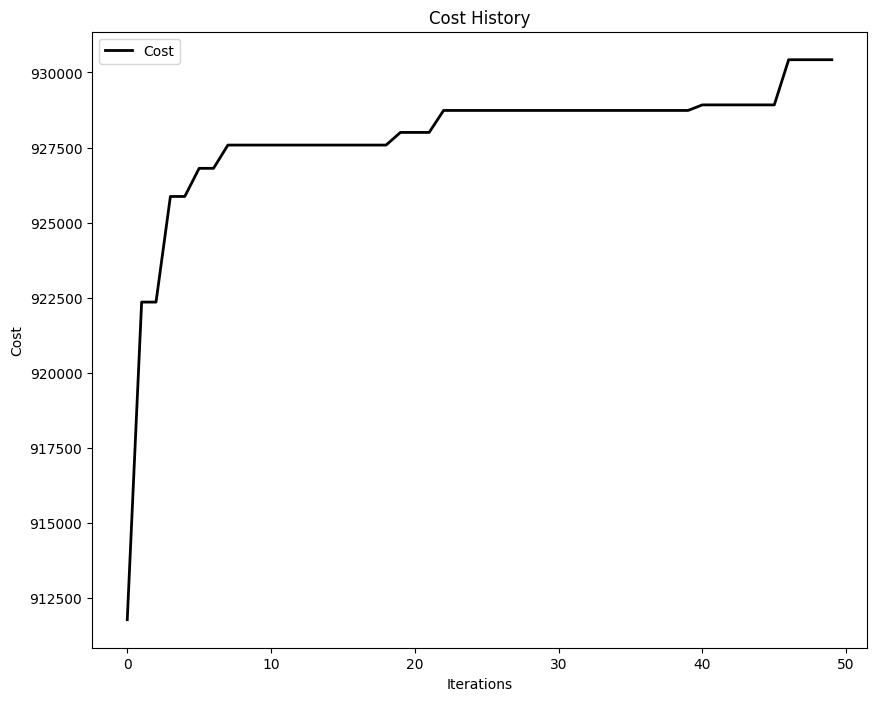

In [13]:
resultPSO.SaveResult(result)